#### Load GPT 2 Model
GPT2 is a small model that can be used for small real time tasks where speed of the model is very important

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

/Users/kosisochukwuasuzu/Developer/ai-startups/test-demos/pdfchat/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer_config.json: 100%|██████████| 26.0/26.0 [00:00<00:00, 75.6kB/s]


In [3]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [9]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [10]:
with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits
print(logits.shape)

torch.Size([1, 7, 50257])


In [11]:
last_logits = logits[0, -1, :]
next_token_id = last_logits.argmax()
next_token_id

tensor(13990)

In [12]:
tokenizer.decode(next_token_id)

' fence'

In [14]:
top_k = torch.topk(last_logits, k=10)
tokens = [tokenizer.decode(tk) for tk  in top_k.indices]
tokens

[' fence',
 ' edge',
 ' railing',
 ' wall',
 ' table',
 ' tree',
 ' top',
 ' counter',
 ' ground',
 ' side']

In [16]:
next_inputs = {
    "input_ids":torch.cat([inputs["input_ids"], next_token_id.reshape((1,1))], dim=1),
    "attention_mask": torch.cat([inputs["attention_mask"], torch.tensor([[1]])], dim=1),
}

In [17]:
next_inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262, 13990]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [18]:
with torch.no_grad():
    outputs = model(**next_inputs)

In [20]:
outputs.logits.shape

torch.Size([1, 8, 50257])

In [21]:
logits = outputs.logits[0, -1, :]

In [22]:
next_token_id = logits.argmax()

In [23]:
out = tokenizer.decode(next_token_id)

In [24]:
out

' and'

##### Extend this to be able to create dynamic sequences
We can extend this method to be able to create dynamic sequences by including a for-loop in the token generation process and feeding the previous outputs back to the model autoregressively

In [25]:
def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    last_logit = logits[0, -1, :]
    next_token_id = last_logit.argmax()
    return next_token_id

In [28]:
generated_tokens = []
next_inputs = inputs
durations_s = []

for _ in range(10):
    t0 = time.time()
    next_token_id = generate_token(next_inputs)
    durations_s += [time.time() - t0]
    
    next_inputs = {
        "input_ids": torch.cat(
            [next_inputs["input_ids"], next_token_id.reshape((1,  1))], dim=1),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])], dim=1)
    }
    
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)
    
    
print(f"{sum(durations_s)}")
print(generated_tokens)

0.445720911026001
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence']


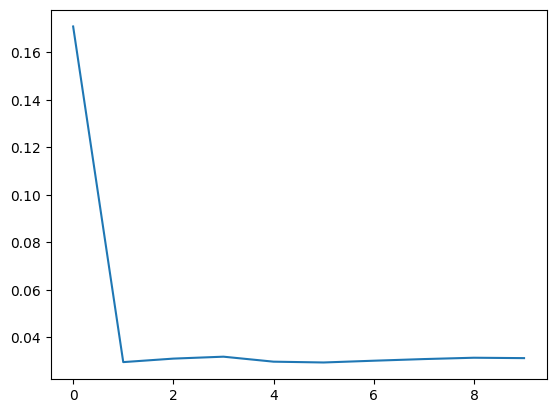

In [29]:
plt.plot(durations_s)
plt.show()

#### Speeding up text geenration with KV-caching
KV-caching is a technique to speed up token generation by storing some of the tensors in the attention head for use in subsequent generation steps

In [31]:
def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values

In [34]:
generated_tokens = []
next_inputs = inputs
duration_cached_s = []

for _ in range(10):
    t0 = time.time()
    next_token_id, past_key_values = generate_token_with_past(next_inputs)
    duration_cached_s += [time.time() - t0]
    
    next_ipnuts = {
        "input_ids": next_token_id.reshape((1, 1)),
        "attention_mask": torch.cat([next_inputs["attention_mask"], torch.tensor([[1]])], dim=1),
        "past_key_values": past_key_values
    }
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)
    
    
print(f"{sum(duration_cached_s)} s")
print(generated_tokens)

0.277385950088501 s
[' fence', ' fence', ' fence', ' fence', ' fence', ' fence', ' fence', ' fence', ' fence', ' fence']


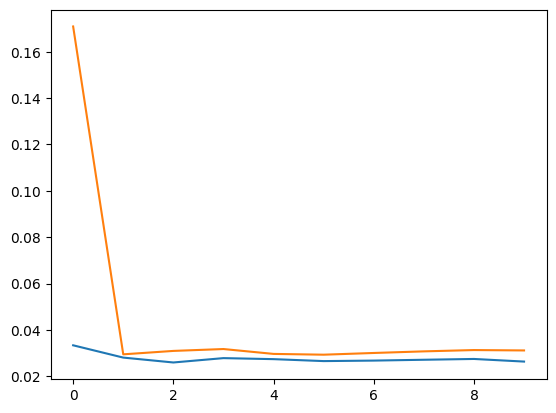

In [37]:
plt.plot(duration_cached_s)
plt.plot(durations_s)
plt.show()